# Multivariate time series: data analysis and preprocessing

## Dataset

The data for this assignment contains time series for hourly weather parameters and pollution in the Chinese city of Bejing. The total data set contains 5 years of measurements, of which the last year is to be used as a test set.

In this notebook, we show how to import and visualise the raw data and demonstrate some useful ways of preprocessing in order to make the features more useful as inputs to a neural network. 

** Warning:** the provided feature transformations are plausible ones, for which we provide code to help students who are less proficient in coding. It is up to you to decide which features (original or transformed) you will use in your model(s).

No code for detrending is provided. Visual inspection shows no obvious global trend but possibly a weak seasonal trend in the labels (pollution). 
You may use detrending on the features and the labels if you choose (a hint is given below). However, as this is not the main focus of this assignment, it should probably not be the first thing you invest in. Also, make sure any trends are ONLY determined on the training data! This means that, for your final models (trained on train+val), you will use a second detrender that is fitted on that larger data set!

## Imports and Drive mounting


In [1]:
#imports and Drive mounting
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

print(tf.__version__)

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
import pandas as pd
from pandas import read_csv
from datetime import datetime
import math
import os

# fix random seed for reproducibility
seed = 2020
np.random.seed(seed)  

from sklearn.model_selection import train_test_split

from tensorflow.keras.datasets import cifar100
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D
from tensorflow.keras.layers import LSTM, GRU
from tensorflow.keras.regularizers import L1L2
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model
from tensorflow.keras import optimizers


TensorFlow 2.x selected.
2.1.0


In [32]:
from google.colab import drive
drive.mount('/content/gdrive')

!ls '/content/gdrive/My Drive/Colab Notebooks/DL2020/GA3/'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
pollution_data.csv


## Reading the data set

The data is provided as a ".csv" file along with the getting started notebooks on Ufora. The easiest way to use it is to put it in your Drive folder and import it from there. 

For reading 'csv' files, using the pandas library is the easiest. This gives you back the data as a pandas dataframe. The code below imports the data and visualises the raw time series.


In [33]:
# load dataset

# The PATH setting below assumes you just uploaded the data file to your Colab session
# When using Drive: replace this by the path where you put the data file
DATAPATH = '/content/gdrive/My Drive/Colab Notebooks/DL2020/GA3/'  

DATAFILE = DATAPATH+'pollution_data.csv'
dataset = read_csv(DATAFILE, header=0, index_col=0)
dataset.head()

,year,month,day,hour,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
24,2010,1,2,0,129,-16,-4.0,1020.0,SE,1.79,0,0
25,2010,1,2,1,148,-15,-4.0,1020.0,SE,2.68,0,0
26,2010,1,2,2,159,-11,-5.0,1021.0,SE,3.57,0,0
27,2010,1,2,3,181,-7,-5.0,1022.0,SE,5.36,1,0
28,2010,1,2,4,138,-7,-5.0,1022.0,SE,6.25,2,0


Dataset has  43800  samples and  12  features


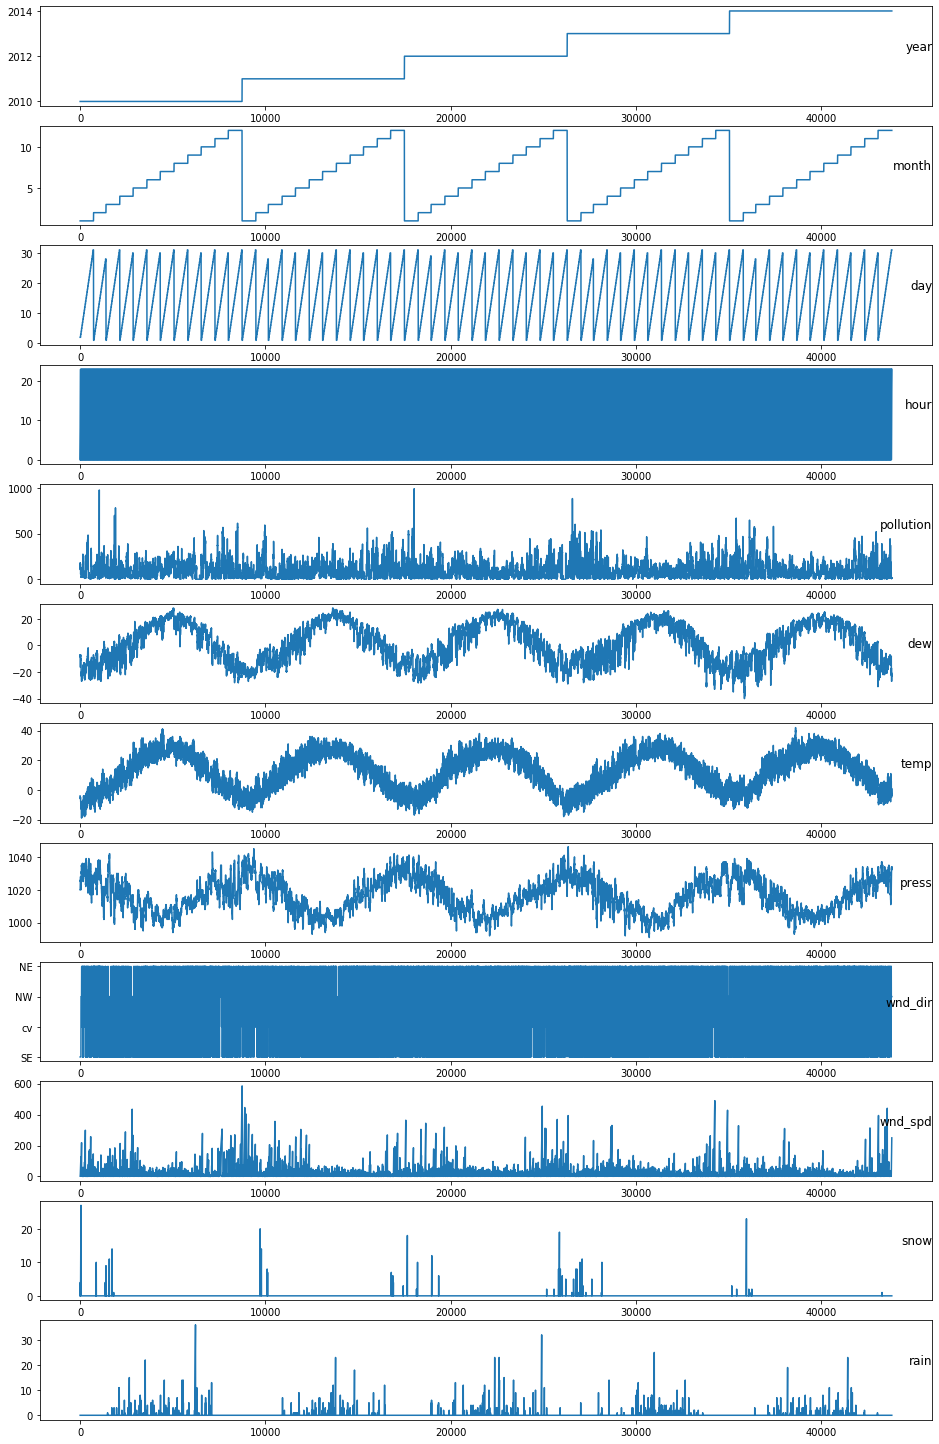

In [34]:
values = dataset.values

# plotting the first k samples of the raw time series
# setting below for all samples
samples = values.shape[0]   
# setting below for smaller number of samples to "zoom in", e.g., 1000
#samples = 1000


print("Dataset has ",values.shape[0]," samples and ",values.shape[1], " features")
# specify columns to plot
groups = [0,1,2,3,4,5,6,7,8,9,10,11]
i = 1
# plot each column
plt.figure(figsize=(16,26))
for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(values[:samples, group])
    plt.title(dataset.columns[group], y=0.5, loc='right')
    i += 1
plt.show()

## Discrete and categorical features

Most of the features are numeric. However, some of those numbers are discrete:
- year: 2010, 2011, 2012, 2013, 2014
- month: 1, ..., 12
- day: 1, ..., 31 (note that not all months have the same number of days)
- hour: 0, ..., 23

Wind directions are categorical values, coded as ['NE' 'NW' 'SE' 'cv'].

In order to decide what to do with those, we should think about the problem again (domain knowledge). 

**Year:** We need to use the year in order to extract the test set further on. Aside from that, there are no indications that the pollution is systematically rising, so it will probably not be useful for detrending or as an input feature to the model.

**Month:** There is a vague seasonal trend in the pollution, so knowing the month is definitely could be useful useful. However, we can see clear seasonal trends in some of the wheather parameters (dew, temperature and pressure), so the month information may already be sufficiently present in these features. This means that in a first attempt, you could probably ignore the month feature.  

If you do use the month, its current 'encoding' does not match very well with the observed seasonal trends, which look like shifted sine signals. Below, we show how you can re-encode the months into sine and cosine signals, with which you can approximate any shifted sinusoidal signal with the same period. You could try to use these to detrend the 'periodic' features (trend is a linear combination of sine, cosine and a constant value). Either you can also detrend the labels, or you can input sine and cosine as separate features. 

**Day:** The day of the month does not seem very relevant to predict pollution, but the day of the week could be. Below, we provide code examples with which you can extract the day of the week and convert it to one-hot code in two ways: one way encodes each day separately, the other only discriminates between weekend and week days. In Belgium, the second option would be very relevant, but since we don't know commuter patterns in Bejing, it may be better to keep all days. You could also plot statistical data for each weekday to check whether there is any significant difference between different days of the week.

**Hour:** Time of day is probably relevant. You could use it as it is or you could consider a similar approach to what we did with the month: transforming into periodic sine and cosine signals and use these as features instead. Again, investigating the statistics for different times of day can help you decide.


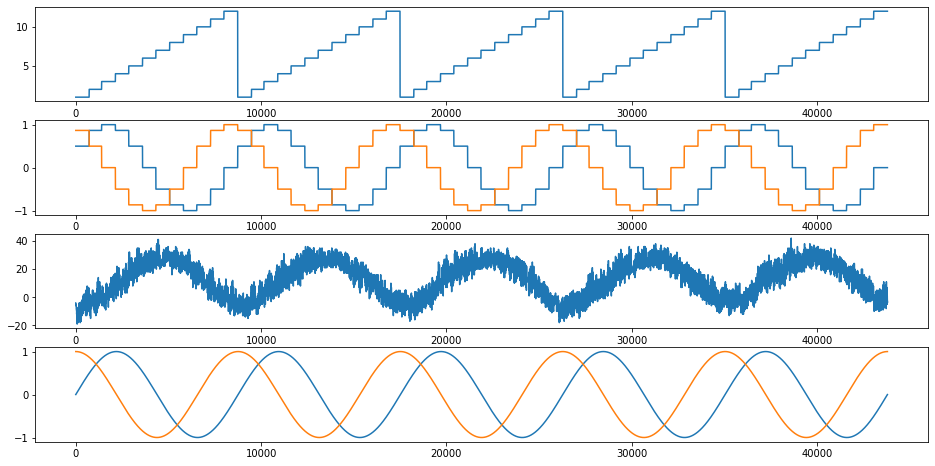

In [35]:
# Translating periodic discrete features into sines and cosines
monthp = values[:,1:2]*2.0*np.pi/12.0
month_sin = np.sin(np.array(monthp,dtype=np.float64))
month_cos = np.cos(np.array(monthp,dtype=np.float64))

# check - note that you would get a much smoother curve if you would use the day of the year
plt.figure(figsize=(16,8))
plt.subplot(4,1,1)
plt.plot(values[:,1:2])
plt.subplot(4,1,2)
plt.plot(month_sin)
plt.plot(month_cos)
plt.subplot(4,1,3)
plt.plot(values[:,6]) # plot temp for comparison

# We see that the transformed month curves are not very smooth. In fact, it is probably better to ignore the months 
# altogether and just use the day-of-the-year index to generate the periodic features
seasons = np.reshape(np.arange(values.shape[0])*2.0*np.pi/(365.0*24),(values.shape[0],1))
seasons_sin = np.sin(np.array(seasons,dtype=np.float64))
seasons_cos = np.cos(np.array(seasons,dtype=np.float64))

# check - note that you would get a much smoother curve if you would use the day of the year
plt.subplot(4,1,4)
plt.plot(seasons_sin)
plt.plot(seasons_cos)
plt.show()

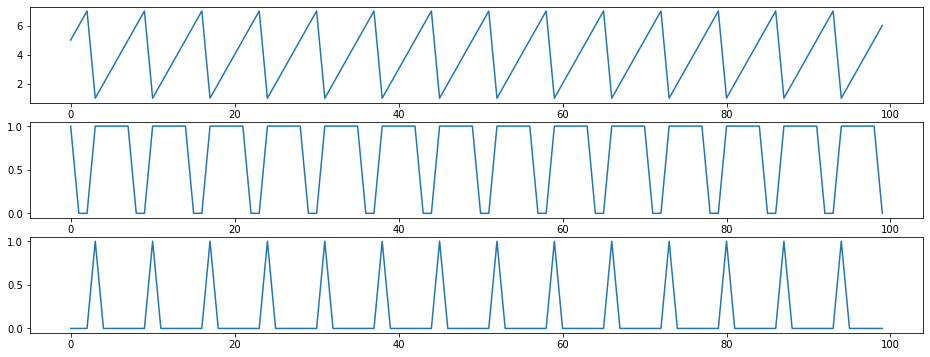

In [36]:
# Day of the week: take into account that 1/1/2010 was a Friday (you can look this up online)
days = np.zeros((values.shape[0],1))

# choose Monday to be day 1
day = 4
for idx in range(values.shape[0]):
  days[idx,0] = day + 1
  day = (day + 1) % 7

weekdays = np.ones_like(days)
weekdays[np.where(days>5)] = 0.0

mondays = np.zeros_like(days)
mondays[np.where(days==1)] = 1.0

## check
plt.figure(figsize=(16,6))
plt.subplot(3,1,1)
plt.plot(days[:100])
plt.subplot(3,1,2)
plt.plot(weekdays[:100])
plt.subplot(3,1,3)
plt.plot(mondays[:100])
plt.show()

We must now also convert the wind direction features to sensible numbers: possible options are integer, one-hot, 2D, polar, ...

From the original paper in which this dataset was introduced, we see that the three unique categories ['NE' 'NW' 'SE' 'cv'] are actually aggregates. The first three are bucketed according to the positions of large industrial sites around Bejing, whereas the fourth corresponds to "calm and variable": 

**Source:** https://royalsocietypublishing.org/doi/10.1098/rspa.2015.0257 :

**Quote:** "* ... northwest (NW), which includes W, WNW, NW, NNW and N; northeast (NE), for NNE, NE and ENE; southeast (SE), covering E, ESE, SE, SSE and S; southwest (SW), having SSW, SW and WSW; and calm and variable (CV).*"

From this perspective, one-hot seems to be the most sensible option for encoding these.

['NE' 'NW' 'SE' 'cv']


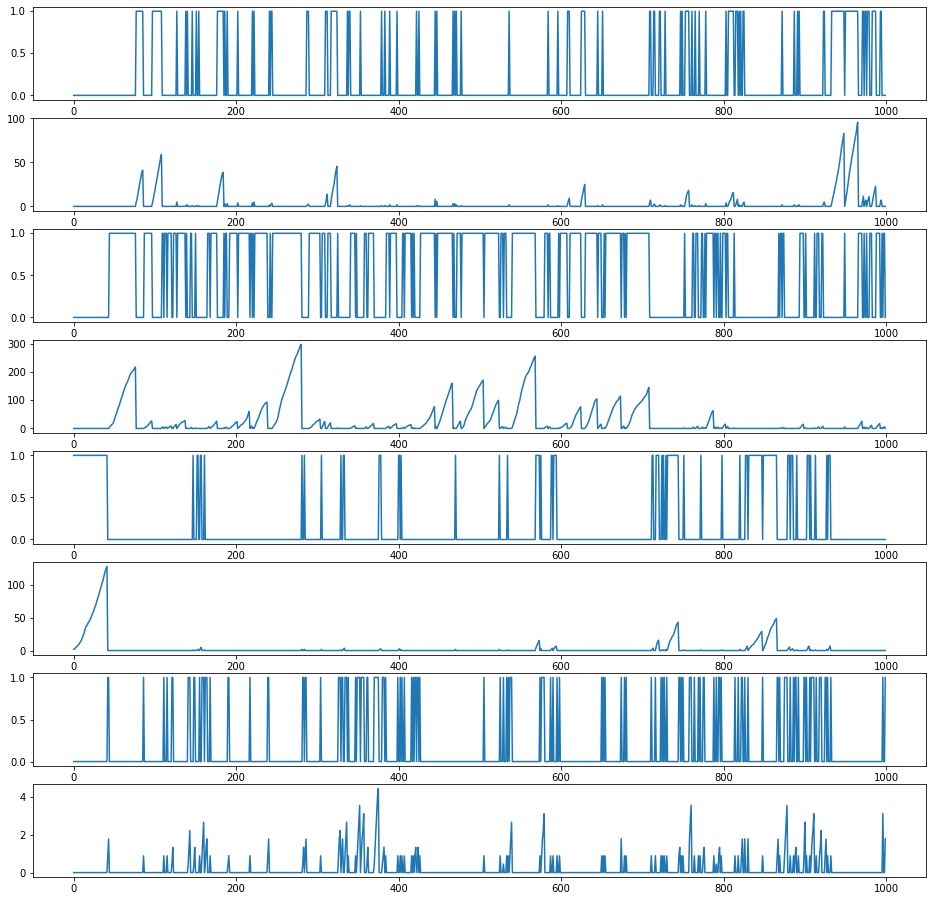

In [37]:
# Wind direction block

# creating two versions of converted feature sets for wind: 
# -  one-hot and wind speed separately (5 feature set) 
# -  4 feature set in which ones of one-hot have been replaced with wind speed

# show unique wind direction values
winddirs = np.unique(values[:,8])
print(winddirs)

dirindices = values[:,8]

encoded_winddir = np.zeros((len(dirindices),4))
encoded_dirstrength = np.zeros((len(dirindices),4))

for idx in range(4):
  indices = np.where(dirindices == winddirs[idx])
  encoded_winddir[indices,idx] = 1.0
  encoded_dirstrength[indices,idx] = values[indices,9]

# check
# Each block of two plots corresponds to a single wind direction
# the top of both is the one-hot version, the botton is one-hot*strength
plt.figure(figsize=(16,16))
for idx in range(4):
    plt.subplot(8, 1, 2*idx+1)
    plt.plot(encoded_winddir[:1000, idx])
    plt.subplot(8, 1, 2*idx+2)
    plt.plot(encoded_dirstrength[:1000, idx])
plt.show()  

With the code above, you should be able to create the features you think are most useful. You can then join them together in a single feature matrix to use for training models:


In [0]:
# helper function
def combine_features(feature_list):
  features = np.concatenate(feature_list,axis=1)
  return features

# the examples below show how you can select and combine the features you need
# NOTE that the selection made here is ONLY an example!!

# create 2 different wind feature sets
fwind4 = combine_features([encoded_dirstrength])
fwind5 = combine_features([values[:,9:10], encoded_winddir])

# create wheather feature set
fweather = values[:,5:8]

# extract pollution features
fpoll = values[:,4:5]

# extract precipitation features (rain/snow)
fwet = values[:,10:]


# Make a feature set of weather, periodic, weekdays, wind4
data=combine_features([fweather,seasons_cos,seasons_sin,weekdays,fwind4])

In [0]:
# you can also add the new features to the pandas dataframe and save that for later reuse
# just a few features added here for demonstration purposes
dataset['cos']=seasons_cos
dataset['sin']=seasons_sin
dataset['weekdays']=weekdays
dataset['NE_strength']=encoded_dirstrength[:,0]
dataset['NW_strength']=encoded_dirstrength[:,1]
dataset['NS_strength']=encoded_dirstrength[:,2]
dataset['cv_strength']=encoded_dirstrength[:,3]

dataset.head()

In [39]:
NEWDATAFILE = DATAPATH+'preprocessed_pollution_data.csv'
dataset.to_csv(path_or_buf=NEWDATAFILE)

#check
check = read_csv(NEWDATAFILE, header=0, index_col=0)
check.head() # should be exactly the same as dataset.head() above

newvalues=check.values

print(newvalues.shape)

labels = check.columns
print(labels)

(43800, 12)
Index(['year', 'month', 'day', 'hour', 'pollution', 'dew', 'temp', 'press',
       'wnd_dir', 'wnd_spd', 'snow', 'rain'],
      dtype='object')


## Splitting into train and test sets

In order to avoid any problems with data leakage between train and test sets, it is safest to make the split from the very beginning. As stated: the last year is the test set.


In [40]:
# The last year is meant for testing, the year of the data is in the first column
testyear = max(newvalues[:,0])
print("Test set year is ", testyear)

# Find indices of all rows in test year
teststart = np.min(np.where(newvalues[:,0]==testyear)[0])
num_train_samples=teststart
num_test_samples=newvalues.shape[0]-teststart

print("There are ",num_train_samples," samples in the training years")
print("and ",num_test_samples," samples in the test year")

# extract train and test data
train_data = pd.DataFrame(data=newvalues[:teststart,:],columns=labels)
TRAINDATAFILE = DATAPATH+'preprocessed_train_data.csv'
train_data.to_csv(path_or_buf=TRAINDATAFILE)

test_data = pd.DataFrame(data=newvalues[teststart:,:],columns=labels)
TESTDATAFILE = DATAPATH+'preprocessed_test_data.csv'
test_data.to_csv(path_or_buf=TESTDATAFILE)

#check
test_data.head()


Test set year is  2014
There are  35040  samples in the training years
and  8760  samples in the test year


,year,month,day,hour,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
0,2014,1,1,0,24,-20,7,1014,NW,143.48,0,0
1,2014,1,1,1,53,-20,7,1013,NW,147.5,0,0
2,2014,1,1,2,65,-20,6,1013,NW,151.52,0,0
3,2014,1,1,3,70,-20,6,1013,NW,153.31,0,0
4,2014,1,1,4,79,-18,3,1012,cv,0.89,0,0


In addition, it is best to also have a validation set. Here you have 3 options: 
1. You split off an additional year: this makes sure you validate accross all seasons, but then you only have three of the original 5 years left, which may be too little for tuning - you should expect to see an improvement between validate and test (after retrain) scores, though.
2. You split off only a small part, but then you tune your network only on its performance for the end of the year
3. you cut the whole dataset into non-overlapping windows and use a random subset for validation: this spreads you validation accross the seasons, but will contain more data leakage and will introduce problems if the data is not stationary. You could also write more complex code in which you discard any window between training and validation samples (cf. slides).

No approach is perfect. When using option 2, it would be good to check afterwards on the test data whether the errors are not systematically smaller on the part of the year on which you validated. Option three will have to be re-done for each model separately, after converting the training sequence into windows, since it depends on the window-width you use for training.

We leave it up to you how to choose. Since some approaches require more coding than others (i.e., less re-use of the provided code), we will accept that part of your choice is motivated by lack of coding experience. Make sure you motivate your decision and analyse the consequences.

This concludes our example code for data manipulation.

## Assignment overview

In your last graded assignment, you will build a model to predict pollution in a big city on past pollution info as well as past wheather info. You receive a multi-variate time series data set which contains hourly data. 
**Your task is to predict pollution 6 hours ahead** in order to be able to build a citizen warning system. The error measure you need to minimise is Mean Absolute Error. You will **use the pollution samples from the last year for testing**. Obviously, it is also advisable to use a validation set.


Your assignment consists of three steps (please also check the instructions in the slides):

1) First make the following baseline model:

a model that only predicts pollution based on the current values of all input time series (pollution and wheather) to predict for 6 hours ahead, i.e. a purely feature based dense model that does not take history into account; you can also use this  model for an initial investigation of the importance of each feature! 
Note that we already provide an even simpler baseline that simply uses the current pollution value as a prediction.

2) After this baseline, you will make two models that predict pollution 6 hours ahead based on **current pollution and pollution history**, so a single timeseries:
- a window-based 1D convolution network (the window size is an important hyperparameter here)
- a RNN network (LSTM and/or GRU)

3) Combine both into a model that uses current values and histories of multiple time series. You do not need to use all of them if they do not improve validation score. You will analyse the impact of including the different wheather features into your model (feature selection). 

4) You will finally try to crank up your performance by making at least one ensemble. For example, for some features it may not be useful to use history information. You could consider buildin an ensemble of a sequential model with a dense model or of models trained on different subsets of the features.

## Analysis

Since this is a regression task, there are no misclassifications: the analysis should focus on visualising the predictions on train and validate or test sets. Code for this is suggested in the training notebook. Please make sure to not only make the necessary plots, ut also to discuss them for the final model(s) in each stage.

## Timing

**This assignment is considerably more extensive than the previous ones!** try to maximally use the experience you already gained to efficiently tune the networks. Also, once you find a network that is properly tuned, do not waste time on trying to get that extra small improvement. If you have time left after finishing all the tasks, you can still revisit your best model(s) to try and improve!

The deadline for this assignment is **Friday, March 20, 23:30**. 
This means you have 2 weeks: for a good planning, aim at finishing at least parts 1 and 2 in the first week! That way, you can use the hands-on support session to ask us whether you are on the right track.


